## Functions

__Function for getting the dynamic parameters of the cell model__

In [25]:
def get_dyn_param(data,cell_temp):    
    
    ind = np.where(np.array(data['temps']) == cell_temp)[0][0]

    eta = data['etaParam'][ind]
    Q = data['QParam'][ind]
    gamma = data['GParam'][ind]
    M0 = data['M0Param'][ind]
    M = data['MParam'][ind]
    R0 = data['R0Param'][ind]
    RC = data['RCParam'][ind]
    RC = np.exp(-np.divide(1,RC))
    R = data['RParam'][ind]

    return (eta,Q,gamma,M0,M,R0,RC,R)

__OCV calculation for any SOC value Function__

In [26]:
from scipy.interpolate import interp1d

def interp_ocv(z,OCV):
    
    dum = interp1d(z,OCV)
    
    return dum

In [27]:
def OCV_from_SOC(z,temp,SOC,OCV_0,OCV_rel):

    # OCV calculation from the given SOC (Coloumb Counting)

    OCV_0_z = interp_ocv(SOC,OCV_0)(z)
    OCV_rel_z = interp_ocv(SOC,OCV_rel)(z)

    ocv_z = OCV_0_z + temp*OCV_rel_z
    
    # Setting the short-circuit cell voltage to zero
    # As there is no battery source at the resitor
    
    ocv_z[np.isnan(z)] = 0

    return (ocv_z)

## Main Code

__Importing Dynamic Model__

In [28]:
data = pd.read_pickle('E2model.pkl')

__User Inputs__

In [29]:
# Number of cells in series in a module
Ns = 5

# Number of modules in parallel
Np = 3

# Simulation Time
max_time = 4800

# Pack rests at time t0
t0 = 2700

# Storage variable
z_pack = np.zeros((max_time,Ns,Np))
i_pack = np.zeros((max_time,Ns,Np))

# Initial state of the cells in the pack
z = 0.25*np.ones((Ns,Np))
irc = np.zeros((Ns,Np))
h = np.zeros((Ns,Np))

# Cell Interconnect resistance
R_inter = 125e-6

# Cell Temperature
# It is assumed that the cell temperature remains constant at 25°C
cell_temp = 25

# Random values initialization
random_init = 1

In [30]:
# Cell Parameters calculated from dynamic model

eta = get_dyn_param(data,cell_temp)[0]*np.ones((Ns,Np)) 
Q = get_dyn_param(data,cell_temp)[1]*np.ones((Ns,Np)) 
gamma = get_dyn_param(data,cell_temp)[2]*np.ones((Ns,Np)) 
M0 = get_dyn_param(data,cell_temp)[3]*np.ones((Ns,Np)) 
M = get_dyn_param(data,cell_temp)[4]*np.ones((Ns,Np)) 
R0 = get_dyn_param(data,cell_temp)[5]*np.ones((Ns,Np)) 
RC = get_dyn_param(data,cell_temp)[6]*np.ones((Ns,Np)) 
R = get_dyn_param(data,cell_temp)[7]*np.ones((Ns,Np)) 

# Static Parameters
SOC = data['SOC']
OCV_0  = data['OCV0']
OCV_rel = data['OCVrel']

In [31]:
# Fault parameters

# 1.Open Cicuit fault
# Cell will have infinite resistance

R0_open = np.inf

# 2.Short circuit fault
# During short circuit SOC cannot be measured
# We will assume some resistance for the cell

z_short = np.nan
R0_short = 0.0025

In [32]:
if random_init:
    
    z = 0.25 + 0.4*np.random.rand(Ns,Np)
    Q = 4.5 + np.random.rand(Ns,Np)
    R0 = 0.005 + 0.020*np.random.rand(Ns,Np)

In [33]:
# Updating the cell resistance with interconnect resistance

R0 = R0 + 2*R_inter

__Simulation Parameters__

In [34]:
# Pack capcity is minimum module capacity

module_cap = np.min(Q,axis = 0)
pack_cap = np.sum(module_cap)

# Charge/Discharge current
# 10C charge/discharge

I = pack_cap*10

In [35]:
# Author has not included this step. If we do not set the voltage to zero,
# Hysterisis ans Diffusion voltage terms are also added in the calculation
# It is to be confirmed in theory if the cell is cutoff or not
    
#     # Setting the short-circuit cell voltage to zero
#     # As there is no battery source at the resitor
#     v[np.isnan(v)] = 0

# The logic is incorporated in OCVfromSOC function

for k in np.arange(0,max_time,1):
    
    
    # =========== Terminal Voltage Calculation =========== 

    v = OCV_from_SOC(z,cell_temp,SOC,OCV_0,OCV_rel)
    v = v + np.multiply(M,h) - np.multiply(R,irc)
    
    # If the cell is short-ciruit then current is going to external resitor
    R0[np.isnan(z)] = R0_short
    
    # =========== Pack voltage calculation ===========
    
    # Module voltage
    Vm = np.sum(v,axis = 0)

    # Module current calculation
    im = np.sum(np.divide(v,R0),axis = 0) 

    # Module equivalent resistance reciprocal
    r_m = np.sum(R0,axis = 0)

    # Pack current calculation
    i_pack = np.sum(im)

    # Inverse of Resisitance of Pack
    r_invm = np.sum(np.divide(1,R0))

    # Pack Voltage
    V_pack = i_pack/r_invm

    # Cell Current
    i_cell = np.divide((Vm - V_pack),r_m)
    i_cell = np.tile(i_cell,Ns).reshape(Ns,Np)

    # Cell new SOC calculation
    z = z-(1/3600)*(np.divide(i_cell,Q))
    
    # Short-circuiting the cell below discharge capacity
    z[z<0] = np.nan

    # Updating the capacitor volage
    irc = np.multiply(RC,irc) + np.multiply((1-RC),i_cell)

    # =========== Hysterisis calculation ===========

    fac = -np.abs(np.multiply(gamma,i_cell))
    fac = np.divide(fac,(3600*Q))
    fac = np.exp(fac)

    # Hysterisis voltage
    h = np.multiply(fac,h) + np.multiply((1-fac),np.sign(i_cell))

    # =========== Charging/Discharging Strategy =========== 

    if np.nanmin(z)<0.05:

        # Start charging
        I = -abs(I)
#         print('Charging')

    elif np.nanmax(z)>0.95:

        # Start Discharging
        I = abs(I)
#         print('Discharging')

    elif k >= t0:

        # Cell Rests
        I = 0
#         print('Rest')

    z_pack[k] = z
#     i_pack[k] = i_cell[0]


C:\Users\spbhatkar.AHEAD\AppData\Local\Temp\ipykernel_8504\2133994556.py:66: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(z)<0.05:
C:\Users\spbhatkar.AHEAD\AppData\Local\Temp\ipykernel_8504\2133994556.py:72: RuntimeWarning: All-NaN slice encountered
  elif np.nanmax(z)>0.95:


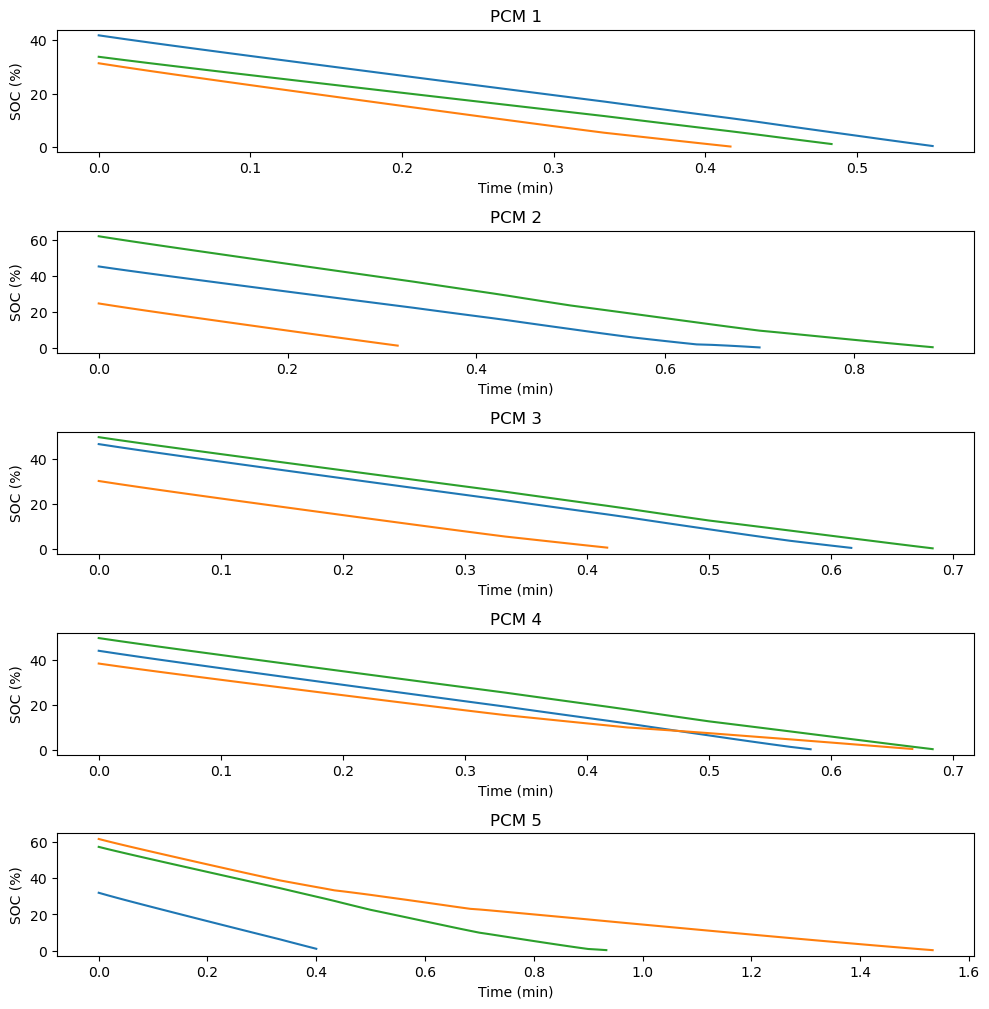

In [36]:
# =========== Cell SOC variation ===========

# Create the figure and axis objects
fig, ax = plt.subplots(Ns, 1, figsize=(10,10))

for i in range(Ns):
    
    z_cell = z_pack[:,i,:]

    # Plot the first curve on the first subplot
    ax[i].plot(np.arange(0,len(z_cell),1)/60,z_cell*100)
    
    title_string = f'PCM {i+1}'
    ax[i].set_title(title_string)
    plt.tight_layout()
    ax[i].set_xlabel('Time (min)')
    ax[i].set_ylabel('SOC (%)')
    

In [37]:
z_module = np.zeros((max_time,Ns))

for i in range(max_time):

    z_module[i] = np.nanmean(z_pack[i],axis = 1)

C:\Users\spbhatkar.AHEAD\AppData\Local\Temp\ipykernel_8504\352936631.py:5: RuntimeWarning: Mean of empty slice
  z_module[i] = np.nanmean(z_pack[i],axis = 1)


In [38]:
# # =========== Cell SOC variation ===========

# plt.clf()

# for i in range(Ns):
    
#     # Plot the first curve on the first subplot
#     plt.plot(np.arange(0,len(z_module),1)/60,z_module[:,i]*100)
    
#     title_string = f'Module Average SOC'
#     plt.title(title_string)
#     plt.tight_layout()
#     plt.xlabel('Time (min)')
#     plt.ylabel('SOC (%)')
    

In [39]:
?